# Chemical Embeddings

This notebook functions very similarly to the previous one, except instead of training on words, we're going to do it on molecular fingerprints. This isn't particularly useful, but it's a natural conceptual continuation from the previous example. We will be using the same graph style as the previous notebook, but instead we'll graph molecules by similarity. This is a form of unsurpervised learning, so it's simply learning to distinguish between these chemicals, reduce them in dimension, and then serve them back up to us.

In [1]:
# Do the imports
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import plotly.graph_objects as go
import gzip
from tqdm import tqdm
import pickle
import os
import requests
import sys
import random


## Download and Load Dataset

We'll be using a subset of the GDB-13 dataset, a database of nearly 1 billion stable and synthetically accessible organic molecules, for our analysis. If the dataset is not present in our directory, we'll download it. We limit our analysis to the first 100,000 SMILES strings for simplicity.


In [2]:

# Function to download dataset
def download_dataset(url, filename):
    print(f"Downloading dataset from {url}...")
    response = requests.get(url)
    with open(filename, 'wb') as f:
        f.write(response.content)
    print("Download complete.")

# Check if dataset exists, if not, download it
dataset_filename = 'GDB13_Subset-ABCDEFGH.smi.gz'
dataset_url = 'https://zenodo.org/record/5172018/files/GDB13_Subset-ABCDEFGH.smi.gz?download=1'
if not os.path.exists(dataset_filename):
    download_dataset(dataset_url, dataset_filename)

# Load the dataset
print("Loading dataset...")
with gzip.open(dataset_filename, 'rb') as f:
    file_content = f.read().decode('utf-8').split('\n')
    smiles = [line.split()[0] for line in file_content if line][:100000]  # Limit to first 100,000 SMILES strings


Loading dataset...



## Compute Molecular Fingerprints

Next, we'll compute the molecular fingerprints for our dataset. This involves converting the SMILES strings to molecular objects using RDKit, then generating a bit vector representation of the molecular structure using the Morgan algorithm (also known as circular fingerprints).

We'll also save the fingerprints to a file, so we don't have to recompute them every time.


In [3]:

# Function to compute molecular fingerprint
def compute_fingerprint(smi):
    mol = Chem.MolFromSmiles(smi)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2)
    return np.array(fp)

# Check if fingerprints file exists, if not, compute fingerprints
fps_filename = 'fingerprints.pkl'
if os.path.exists(fps_filename):
    print("Loading fingerprints from file...")
    with open(fps_filename, 'rb') as f:
        fps = pickle.load(f)
else:
    print("Generating molecular fingerprints...")
    fps = np.array([compute_fingerprint(smi) for smi in tqdm(smiles, file=sys.stdout)])  # Added file=sys.stdout

    print("Saving fingerprints to file...")
    with open(fps_filename, 'wb') as f:
        pickle.dump(fps, f)


Loading fingerprints from file...



## Select Subset for Visualization

For visualization purposes, we'll randomly select 100 SMILES strings and compute their fingerprints.


In [4]:

# Randomly select 100 SMILES strings for visualization
smiles_to_visualize = random.sample(smiles, 100)

# Get the fingerprints for the selected SMILES strings
fps_to_visualize = np.array([compute_fingerprint(smi) for smi in smiles_to_visualize])



## Dimensionality Reduction

We'll use t-SNE, a machine learning algorithm for dimensionality reduction, to transform our high-dimensional fingerprint vectors into 3-dimensional vectors for visualization. After computing the t-SNE transformation, we'll normalize the output to be between -1 and 1.

Note that in this case we did not train any model! This is because we can directly consider the molecular fingerprint as the embedding of a molecule, and simply use t-SNE directly to reduce the dimensionality down to a visualizable number.


In [5]:

# Compute the t-SNE transformation for 3D
print("Computing t-SNE...")
tsne = TSNE(n_components=3, random_state=42, init='pca', learning_rate='auto', n_iter=1000)  # Added init and learning_rate parameters
fps_3d = tsne.fit_transform(fps_to_visualize)

# Normalize the output to be between -1 and 1
print("Normalizing output...")
scaler = MinMaxScaler(feature_range=(-1, 1))
fps_3d = scaler.fit_transform(fps_3d)


Computing t-SNE...
Normalizing output...



## Compute Spherical Coordinates

Next, we'll compute the spherical coordinates for our 3D vectors. This involves computing two angles, theta and phi, for each point. Theta is the angle in the XY plane (counterclockwise from the X-axis), and phi is the angle from the Z axis.


In [6]:

# Compute the spherical coordinates
print("Computing spherical coordinates...")
theta_fps = np.arctan2(fps_3d[:, 1], fps_3d[:, 0])
phi_fps = np.arccos(np.clip(fps_3d[:, 2], -1, 1))  # Added np.clip to avoid invalid values


Computing spherical coordinates...



## Map Fingerprints onto Sphere

Then, we'll map the fingerprints onto a sphere for 3D plot using the computed spherical coordinates.


In [7]:

# Map the fingerprints onto a sphere for 3D plot
print("Mapping fingerprints onto sphere...")
x_3d_fps = np.sin(phi_fps) * np.cos(theta_fps)
y_3d_fps = np.sin(phi_fps) * np.sin(theta_fps)
z_3d_fps = np.cos(phi_fps)


Mapping fingerprints onto sphere...



## Create 3D Plot

Finally, we'll create an interactive 3D plot with the mapped fingerprints and a unit sphere for reference.


In [8]:
# Create an interactive 3D plot
print("Creating 3D plot...")
fig_3d = go.Figure()

# Add the spherical plot of molecular fingerprints
fig_3d.add_trace(go.Scatter3d(
    x = x_3d_fps,
    y = y_3d_fps,
    z = z_3d_fps,
    mode = 'markers',
    name = 'Molecular Fingerprints',
    text = smiles_to_visualize,  # Added this line to display SMILES string on hover
    hoverinfo = 'text',  # Added this line to display only the SMILES string on hover
    marker=dict(
        color='blue',  # set color to blue
        opacity=1.0
    )
))

# Add the unit sphere, but make it slightly smaller so we can see the words easier
print("Adding unit sphere to plot...")
phi = np.linspace(0, 2*np.pi, 100)
theta = np.linspace(0, np.pi, 100)
x_sphere = 0.95 * np.outer(np.cos(phi), np.sin(theta))
y_sphere = 0.95 * np.outer(np.sin(phi), np.sin(theta))
z_sphere = 0.95 * np.outer(np.ones(np.size(phi)), np.cos(theta))

fig_3d.add_trace(go.Surface(
    x = x_sphere,
    y = y_sphere,
    z = z_sphere,
    opacity = 1.0,
    showscale = False,
    name = 'Unit Sphere'
))

fig_3d.update_layout(width=800, height=800, title_text="Molecular Fingerprints Visualized on a Sphere", scene=dict(bgcolor='white'))

print("Displaying plot...")
fig_3d.show()

Creating 3D plot...
Adding unit sphere to plot...
Displaying plot...


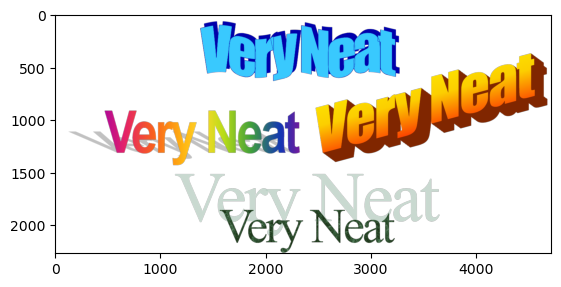

In [9]:
# Very neat.
import matplotlib.pyplot as plt
plt.show(plt.imshow(plt.imread('very-neat.png')))